# 不同初始化大小模型学习复合任务的差异分析

如下图所示，本实验期望研究在给定复合anchor**3 4**的非推断解进行训练的前提下，未见复合anchor**4 3**学到的映射的类型。我们发现不同初始化大小对模型在未见复合anchor**4 3**学到的映射类型有极大影响。因此，我们进一步对不同初始化模型内部机制进行分析。

![aa](./fig/composition_setting_x-6_new.drawio.png)

## 1.训练部分

In [3]:
import argparse
import os

from data import *
from train import *
from model import *
from utils import *



### 1.1 配置超参数及数据集配比设定

In [4]:
dname = ['13_xm0', '23_xm0', '43_xm0', '31_xm0', '32_xm0', '34_xm0'] + ['12_xm0', '14_xm0', '21_xm0', '41_xm0', '24_xm0', '42_xm0'] + ['11_xm0', '22_xm0', '33_xm0', '44_xm0']\
       +['13_xel', '23_xel', '43_xel', '31_xel', '32_xel', '34_xel'] + ['12_xel', '14_xel', '21_xel', '41_xel', '24_xel', '42_xel'] + ['11_xel', '22_xel', '33_xel', '44_xel']
dmode = ['13_xm0', '23_xm0', '43_xm0', '31_xm0', '32_xm0', '34_xm0'] + ['12_xm0', '14_xm0', '21_xm0', '41_xm0', '24_xm0', '42_xm0'] + ['11_xm0', '22_xm0', '33_xm0', '44_xm0']\
       +['13_xel', '23_xel', '43_xel', '31_xel', '32_xel', '34_xel'] + ['12_xel', '14_xel', '21_xel', '41_xel', '24_xel', '42_xel'] + ['11_xel', '22_xel', '33_xel', '44_xel']

dtrain = [0, 0, 0, 0, 0, 0] + [0, 0, 0, 0, 0, 0] + [0, 0, 0, 0] \
       + [1, 1, 0, 1, 1, 1] + [1, 1, 1, 1, 1, 1] + [1, 1, 1, 1]


dshow = [0, 0, 1, 0, 0, 1] + [0, 0, 0, 0, 0, 0] + [0, 0, 0, 1] \
      + [0, 0, 1, 0, 0, 1] + [0, 0, 0, 0, 0, 0] + [0, 0, 0, 1]
dpercent = [1, 1, 1, 1, 1, 1] + [1, 1, 1, 1, 1, 1] + [1, 1, 1, 1] \
         + [9, 9, 9, 9, 9, 9] + [9, 9, 9, 9, 9, 9] + [9, 9, 9, 9]


In [5]:
parser = argparse.ArgumentParser(description="Pytorch distributed")

# 数据集参数
parser.add_argument('-data_size', '--data_size', type = int, default = 900000) 
parser.add_argument('-sl', '--seq_len', type = int, default = 9, help='句子长度')
parser.add_argument('-dmin', '--data_min', type = int, default = 20, help='数据集中数据的最小值')
parser.add_argument('-dmax', '--data_max', type = int, default = 100, help='数据集中数据的最大值')
parser.add_argument('-bs', '--batch_size', type = int, default = 2048) 
parser.add_argument('-seed', '--seed', type = int, default = 1)  

parser.add_argument('-dmode', '--data_mode', nargs='*', type=str, default = [1], help='各类数据集的模式，不同任务中的数据集模式不同')
parser.add_argument('-dp', '--data_percent', nargs='*', type=float, default = [1], help='各类数据集占比')
parser.add_argument('-dn', '--data_name', nargs='*', type=str, default = ['full data'], help='各类数据集名称')
parser.add_argument('-dtrain', '--data_train', nargs='*', type=int, default = [0], help='该类是否参与训练')
parser.add_argument('-dshow', '--data_show', nargs='*', type=int, default = [0], help='画图时是否显示该类数据集，1表示显示，0表示不显示')


parser.add_argument('-vs', '--vocab_size', type = int, default = 201) 
parser.add_argument('-mp', '--max_pos', type = int, default = 20)
parser.add_argument('-dm', '--d_model', type = int, default = 400)
parser.add_argument('-d_ff', '--d_feedforward', type = int, default = 1200)
parser.add_argument('-dk', '--d_k', type = int, default = 200)
parser.add_argument('-dv', '--d_v', type = int, default = 200)
parser.add_argument('-nl', '--n_layers', type = int, default = 2)
parser.add_argument('-nh', '--n_heads', type = int, default = 1)
parser.add_argument('-cl', '--clip', type = int, default = 1, help='梯度裁剪')
parser.add_argument('-cpt', '--checkpoint', type = str, default = 'none', help='预训练模型的存储路径') 

# 训练超参数
parser.add_argument('-ne', '--n_epoch', type = int, default = 210) 
parser.add_argument('-lr', '--lr', type = float, default = 1.e-5, help='初始学习率') 
parser.add_argument('-op', '--optim', choices = ['Adam', 'SGD', 'AdamW'], default = 'AdamW', help='优化器')  
parser.add_argument('-scheduler', '--scheduler', type = str, default= 'GradualWarmupScheduler_CosineAnnealingLR', help='调度器')
parser.add_argument('-lds', '--lr_decay_step', type = int, default = 1000, help='使用StepLR调度器时，每隔多少epoch学习率衰减') 
parser.add_argument('-ldr', '--lr_decay_rate', type = float, default = 1, help='使用StepLR调度器时，学习率变为原来的多少倍') 

parser.add_argument('-optim_total_epoch', '--optim_total_epoch', type = int, default = 10, help='使用GradualWarmupScheduler时的预热的周期数')
parser.add_argument('-optim_multiplier', '--optim_multiplier', type = float, default = 20, help='使用GradualWarmupScheduler时的最大学习率与初始学习率的比值')
parser.add_argument('-optim_T_max', '--optim_T_max', type = int, default = 200, help='使用CosineAnnealingLR时的周期长度，即从当前学习率下降到最小学习率所需的epoch，若继续训练则会按照cosine继续上升到最大学习率，然后再下降')
parser.add_argument('-optim_eta_min', '--optim_eta_min', type = float, default = 1e-5, help='使用CosineAnnealingLR下降到的最小学习率')


# 保存、输出信息和画图的间隔
parser.add_argument('-sme', '--save_model_epoch', type = int, default = 20, help='每隔多少epoch保存一次模型') 
parser.add_argument('-ple', '--print_loss_epoch', type = int, default = 1, help='每隔多少epoch输出一次loss')
parser.add_argument('-pae', '--print_acc_epoch', type = int, default = 3, help='每隔多少epoch输出一次acc')
parser.add_argument('-plae', '--plot_loss_acc_epoch', type = int, default = 3, help='每隔多少epoch画一次loss和acc')

#condense
parser.add_argument('-sr', '--std_rate', type = float, default = 0.1, help='标准差的幂次') 
parser.add_argument('-wdir', '--working_dir', type = str, default = 'result', help='数据存储文件夹')

# 解析参数
args, _ = parser.parse_known_args()

args.data_percent=dpercent
args.data_name=dname
args.data_mode=dmode
args.data_train=dtrain
args.data_show=dshow
args.working_dir=args.working_dir + f'_{args.std_rate}'

# 设置随机种子
setup_seed(args.seed)

# 生成存储数据的文件夹
for file in ['pic', 'loss', 'src', 'data', 'model']:
    os.makedirs(f'{args.working_dir}/{file}', exist_ok=True)

### 1.2 获取数据

In [6]:

#详见data.py文件
datas = get_data(args)



160.0
13_xm0 13_xm0 0.00625
23_xm0 23_xm0 0.00625
43_xm0 43_xm0 0.00625
31_xm0 31_xm0 0.00625
32_xm0 32_xm0 0.00625
34_xm0 34_xm0 0.00625
12_xm0 12_xm0 0.00625
14_xm0 14_xm0 0.00625
21_xm0 21_xm0 0.00625
41_xm0 41_xm0 0.00625
24_xm0 24_xm0 0.00625
42_xm0 42_xm0 0.00625
11_xm0 11_xm0 0.00625
22_xm0 22_xm0 0.00625
33_xm0 33_xm0 0.00625
44_xm0 44_xm0 0.00625
13_xel 13_xel 0.05625
23_xel 23_xel 0.05625
43_xel 43_xel 0.05625
31_xel 31_xel 0.05625
32_xel 32_xel 0.05625
34_xel 34_xel 0.05625
12_xel 12_xel 0.05625
14_xel 14_xel 0.05625
21_xel 21_xel 0.05625
41_xel 41_xel 0.05625
24_xel 24_xel 0.05625
42_xel 42_xel 0.05625
11_xel 11_xel 0.05625
22_xel 22_xel 0.05625
33_xel 33_xel 0.05625
44_xel 44_xel 0.05625


In [7]:
print('datasize:', len(datas['44_xel']), 'example:', datas['44_xel'][0])
print('datasize:', len(datas['11_xm0']), ' example:', datas['11_xm0'][0])
print('datasize:', len(datas['24_xel']), ' example:', datas['24_xel'][0])

datasize: 50625 example: [48, 23, 85, 4, 4, 80, 57, 86, 50, 69]
datasize: 5625  example: [41, 42, 62, 48, 1, 1, 24, 42, 88, 58]
datasize: 50625  example: [37, 44, 46, 87, 63, 30, 2, 4, 58, 23]


### 1.3 训练Transformer模型

In [ ]:
# 训练模型，详见train.py文件
train(args, datas)

training...


### 2.2 查看不同初始化模型在未见anchor43上的准确率

In [8]:
def last_word_acc_reasoning(args, checkpoint, data_loader):
    device = torch.device( "cpu")
    model = myGPT_specific(args, device).to(device)

    model.load_state_dict(torch.load(checkpoint, map_location=device))
    model.eval()
    correct = 0
    total_samples = 0
    
    for i, (dec_inputs, dec_outputs) in enumerate(data_loader):
        dec_inputs, dec_outputs = dec_inputs.to(device), dec_outputs.to(device)
        outputs, _ = model(dec_inputs)
        
        batch_size = dec_inputs.size(0)  # 获取当前批次的实际大小
        total_samples += batch_size
        
        outputs = outputs.argmax(axis=-1).view(-1, args.seq_len)
        correct += (outputs[:, -1] == dec_outputs[:, -1]).sum().item()
    
    return correct / total_samples


def last_word_acc_symmetry(args, checkpoint, data_loader):
    device = torch.device( "cpu")
    model = myGPT_specific(args, device).to(device)

    model.load_state_dict(torch.load(checkpoint, map_location=device))
    model.eval()
    correct = 0
    total_samples = 0
    
    for i, (dec_inputs, dec_outputs) in enumerate(data_loader):
        dec_inputs, dec_outputs = dec_inputs.to(device), dec_outputs.to(device)
        outputs, _ = model(dec_inputs)
        
        batch_size = dec_inputs.size(0)  # 获取当前批次的实际大小
        total_samples += batch_size
        
        outputs = outputs.argmax(axis=-1).view(-1, args.seq_len)
        correct += (outputs[:, -1] == dec_outputs[:, -1]+4).sum().item()
    
    return correct / total_samples


data_loader_group = get_data_loader_group(args, datas)
model_large_init='./result_0.1/model/model_209.pt'
model_middle_init='./result_0.5/model/model_20.pt'
model_small_init='./result_0.8/model/model_209.pt'

small_init_unseen_acc=last_word_acc_reasoning(args, model_small_init, data_loader_group['43_xel'])
middle_init_unseen_acc=last_word_acc_reasoning(args, model_middle_init, data_loader_group['43_xel'])
large_init_unseen_acc=last_word_acc_reasoning(args, model_large_init, data_loader_group['43_xel'])
small_init_unseen_acc_symm=last_word_acc_symmetry(args, model_small_init, data_loader_group['43_xel'])
middle_init_unseen_acc_symm=last_word_acc_symmetry(args, model_middle_init, data_loader_group['43_xel'])
large_init_unseen_acc_symm=last_word_acc_symmetry(args, model_large_init, data_loader_group['43_xel'])
small_init_seen_acc=last_word_acc_reasoning(args, model_small_init, data_loader_group['12_xel'])
middle_init_seen_acc=last_word_acc_reasoning(args, model_middle_init, data_loader_group['12_xel'])
large_init_seen_acc=last_word_acc_reasoning(args, model_large_init, data_loader_group['12_xel'])
print('small_init_unseen_rsn_acc:', small_init_unseen_acc)
print('middle_init_unseen_rsn_acc:', middle_init_unseen_acc)
print('large_init_unseen_rsn_acc:', large_init_unseen_acc)
print('small_init_unseen_sym_acc:', small_init_unseen_acc_symm)
print('middle_init_unseen_sym_acc:', middle_init_unseen_acc_symm)
print('large_init_unseen_sym_acc:', large_init_unseen_acc_symm)
print('small_init_seen_acc:', small_init_seen_acc)
print('middle_init_seen_acc:', middle_init_seen_acc)
print('large_init_seen_acc:', large_init_seen_acc)



small_init_unseen_rsn_acc: 0.9685530864197531
middle_init_unseen_rsn_acc: 0.0
large_init_unseen_rsn_acc: 0.00857283950617284
small_init_unseen_sym_acc: 0.0
middle_init_unseen_sym_acc: 1.0
large_init_unseen_sym_acc: 0.05402469135802469
small_init_seen_acc: 1.0
middle_init_seen_acc: 1.0
large_init_seen_acc: 0.31565432098765434


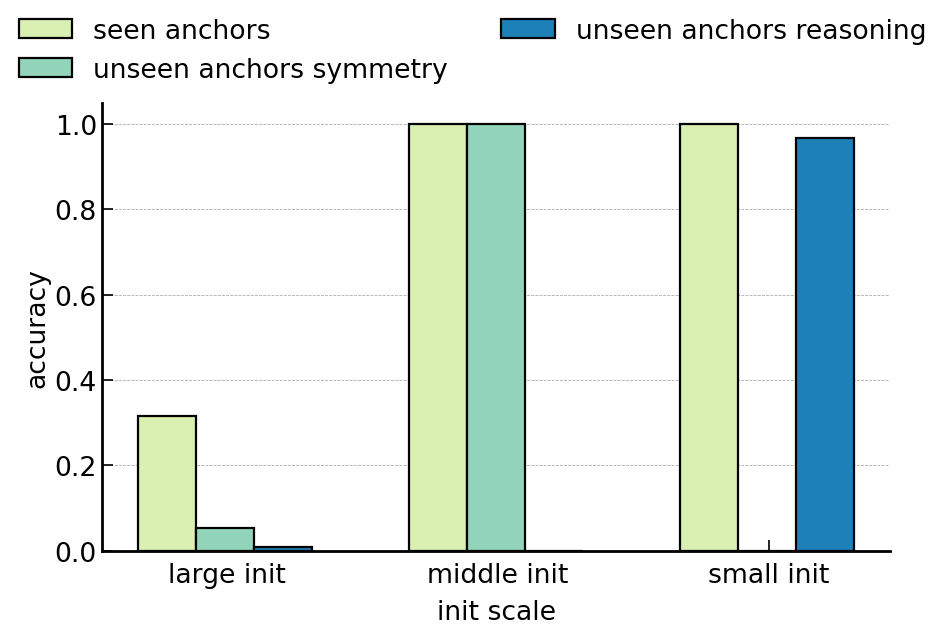

In [13]:
acc_list=[[large_init_seen_acc, middle_init_seen_acc, small_init_seen_acc], [large_init_unseen_acc_symm, middle_init_unseen_acc_symm, small_init_unseen_acc_symm], [large_init_unseen_acc, middle_init_unseen_acc, small_init_unseen_acc]]


fig = plt.figure(figsize=(12, 8))
format_settings(left=0.12, right=0.94, bottom=0.15, top=0.85, major_tick_len=10, fs=24, lw=6, ms=12.5, axlw=2.5)
plt.rcParams['xtick.major.pad'] = 10
plt.rcParams['ytick.major.pad'] = 5

plt.rcParams['axes.spines.top'] = False
plt.rcParams['axes.spines.right'] = False

ax = plt.gca()

labels = ['seen anchors', 'unseen anchors symmetry', 'unseen anchors reasoning']
color_list = [(218/255, 240/255, 178/255), (146/255, 212/255, 185/255), (30/255, 128/255, 184/255)]
width = 0.15
for i, data in enumerate(acc_list):
    ax.bar(np.arange(len(data))*0.7-0.7*width+i*width, data, width=width, 
            label=labels[i], color=color_list[i],edgecolor='black', linewidth=2)
ax.yaxis.grid(True, linestyle='--', linewidth=0.7, color='gray', alpha=0.7)
ax.set_axisbelow(True)
ax.set_xticks([0.05,0.75,1.45])
ax.set_xticklabels(['large init','middle init','small init'])
# ax.set_yticks([0.2, 0.4, 0.6, 0.8, 1.0])
# ax.set_yticklabels(['20%', '40%', '60%', '80%', '100%'])

ax.set_xlabel('init scale', labelpad=10)
ax.set_ylabel('accuracy')

ax.legend(loc=(-0.12, 1.02), frameon=False, ncol=2)
plt.savefig('./acc.png', dpi=300)